# A Multi-Strategy Optimizer

### 📊 Portfolio Optimizer – Multi-Strategy
Builds an **intelligent portfolio optimizer** that can follow **three different strategies**:  

- **Max Sharpe Ratio** → maximize return per unit of risk  
- **Max Expected Return** → focus purely on highest possible return  
- **Min Volatility** → reduce total portfolio risk

<br>

### Why use a **multi-strategy optimizer**?

Because investors have **different objectives** depending on their risk aversion :  
- Some want **the best balance between risk and reward** (Sharpe Ratio)  
- Some want **maximum growth**, even if risk is higher (Expected Return)  
- Some want **stability and low fluctuations** (Min Volatility)

A multi-strategy optimizer lets the investor **choose and compare** these philosophies in one tool.

<br>  

---

<br> 

### 📉 Expected Return
Measures the annualized portfolio return based on asset weights.

$E(R_p) = \sum_{i=1}^{n} w_i \cdot \bar{R_i} \times 252$


- **$E(R_p)$** : expected annual return  
- **$w_i$** : weight of asset *i* in the portfolio  
- **$\bar{R_i}$** : average daily log return of asset *i*  
- **252** : trading days in a year  

<br>

### 📉 Portfolio Volatility
Measures the portfolio’s overall risk level.

$\sigma_p = \sqrt{ w^T \cdot \Sigma \cdot w }$


- **$\sigma_p$** : annualized portfolio volatility  
- **$w$** : weight vector  
- **$\Sigma$** : annualized covariance matrix of asset returns  

<br>

### 📉 Sharpe Ratio
Shows how much excess return is earned per unit of risk.

$S = \frac{E(R_p) - R_f}{\sigma_p}$


- **$S$** : Sharpe ratio  
- **$R_f$** : risk-free rate (e.g., Treasury Bill)  

<br>

### 📉 Beta
Evaluates how sensitive the portfolio is to market movements.

$\beta_p = \frac{Cov(R_p, R_m)}{Var(R_m)}$


- **$\beta_p$** : portfolio beta relative to the market (SPY used here)  
- **$R_p$** : portfolio returns  
- **$R_m$** : market returns  

<br>  

---

<br> 

### 🎯 Strategies

- **1️⃣ Max Sharpe Ratio** → $\max \left( \frac{E(R_p) - R_f}{\sigma_p} \right)$  

Finds weights that deliver **the best return per risk unit**.  
<br>

- **2️⃣ Max Expected Return** → $\max ( E(R_p) )$  

Seeks **highest possible return**, regardless of volatility.  
<br>

- **3️⃣ Min Volatility** → $\min ( \sigma_p )$  

Targets **the lowest overall portfolio risk**.  
<br>

<br>

### 🔧 Constraints

- **Weights sum to 1** :  

$\sum w_i = 1$  

(all capital invested)

- **No short selling & max 50% per asset** :  

$0 \leq w_i \leq 0.5$

<br>  

---

<br> 

### 🎲 Results
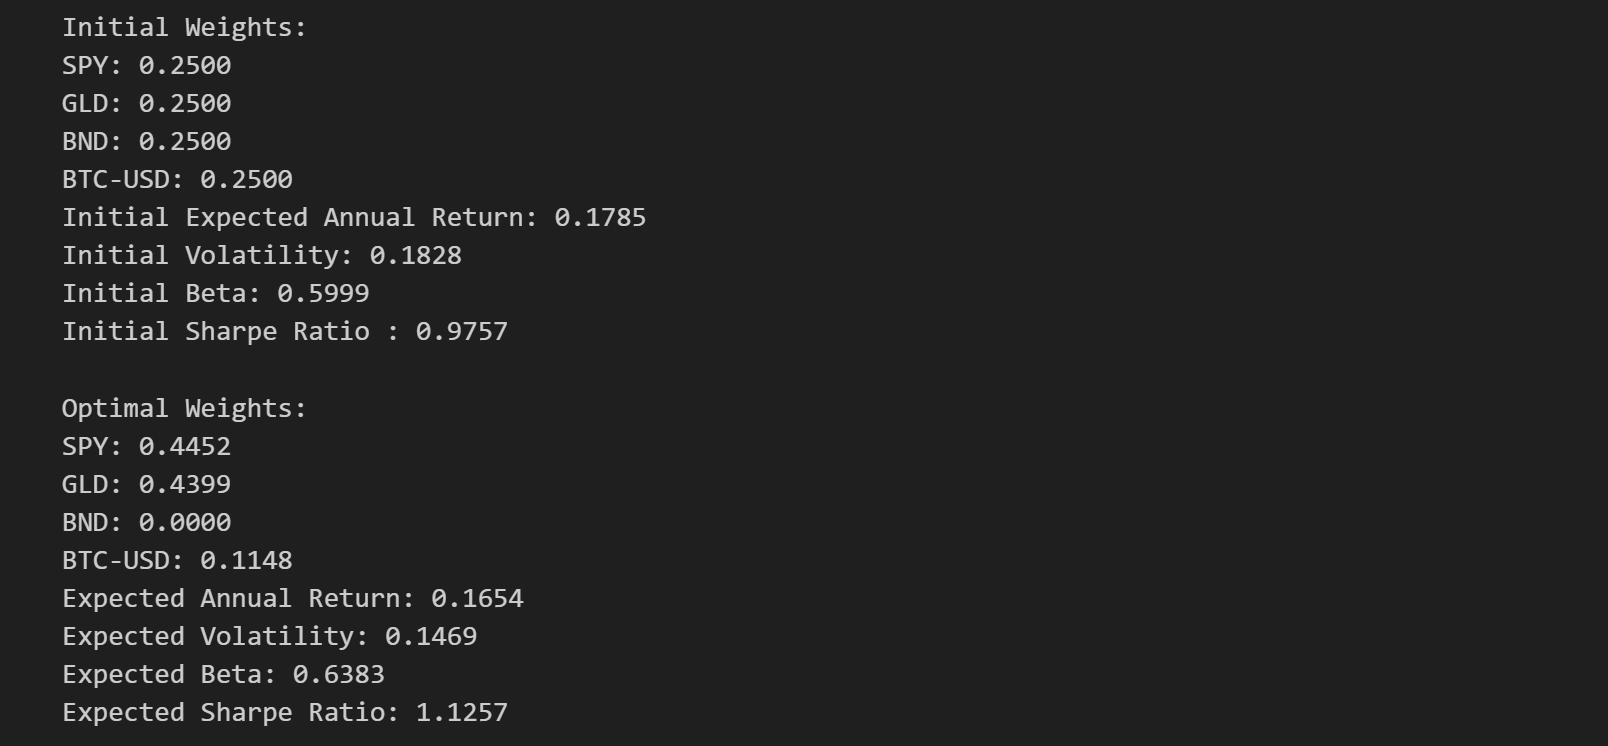

<br>


### The python script

In [1]:
import yfinance as yf                               # données yahoo finance
import pandas as pd                                 # pour avoir des DataFrames (tableau)
import numpy as np                                  # pour les calculs
from datetime import datetime, timedelta
from scipy.optimize import minimize                 # pour l'optimisation et stratégies





# DATA & INPUT SECTION

tickers = input("Enter your assets (ticker) separated by a comma as follows then press enter : SPY, GLD, BND, BTC-USD, ... :\n")
tickers = [t.strip() for t in tickers.split(',')]  # Convertit la chaîne d'entrée en liste [] d'actifs


initial_weights = np.array([float(input(f"Entrer your allocation over 1 (20% = 0.2) for {ticker} : ")) for ticker in tickers]) 


end_date = datetime.today()
annees = int(input("Enter the number of years you want to consider (ex : 5) : "))
start_date = end_date - timedelta(annees * 365)


tableau_df = pd.DataFrame()

for x in tickers :                                  # pour chaque asset de la liste, download toutes ses datas yahoo finance des x dernieres années en input
    data = yf.download(x, start_date, end_date)     # Remplis la DataFrame
    tableau_df[x] = data['Close']


risk_free_rate = 0.02 / 252 

# Download des données du marché de référence (SPY) pour le calcul du beta
market_ticker = "SPY"
market_data = yf.download(market_ticker, start_date, end_date)
market_returns = np.log(market_data['Close'] / market_data['Close'].shift(1)).dropna()






# CALCULUS SECTION

log_returns = np.log(tableau_df / tableau_df.shift(1))      # calcul des rendements log ->  plus stable et symétrique que rendement simple
log_returns = log_returns.dropna()                          # supprimer les lignes avec des valeurs NaN 

# Calcul de la matrice de covariance des rendements
cov_matrix = log_returns.cov()*252                          # matrice(tableau) de covariance des rendements log entre nos actifs, 
#print(cov_matrix)                                          # *252 pour annualiser la covariance (252 jours de bourse par an)


def standard_deviation(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))      # formule de l'écart-type des rendements pondérés par les poids des actifs grace aux méthodes numpy (np.dot) pour les multiplications matricielles ou @

def exp_returns(weights, log_returns):
    return np.sum(log_returns.mean() * weights) * 252                   # exp_returns != log_returns car le deuxieme est ~ le rendement jounalier.

def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    returns = exp_returns(weights, log_returns)                         # calcul des rendements espérés
    volatility = standard_deviation(weights, cov_matrix)                # calcul de la volatilité
    return (returns - risk_free_rate) / volatility                      # calcul du Sharpe ratio : stratégie visant a maximiser le ratio, Viser le 2.

def beta(weights, log_returns, market_returns):
    """
    Calcule le beta moyen du portefeuille par rapport à un indice de marché --> le SP500 'SPY' pour l'instant.

    Parameters:
    - weights: array (liste) des poids du portefeuille (somme = 1)
    - log_returns: DataFrame des rendements log des actifs du portefeuille
    - market_returns: Series des rendements log du marché (ex: SPY)
    """

    cov_with_market = log_returns.apply(lambda x: x.cov(market_returns)) * 252      # Covariance entre chaque actif et le marché (annualisée)
    var_market = market_returns.var() * 252                                         # Variance du marché (annualisée)
    
    betas = cov_with_market.values / var_market                                     # Convert betas to numpy array
    weights = np.array(weights)                                                     # Ensure weights is a numpy array
    beta_portfolio = np.dot(weights, betas)                                         # Beta moyen pondéré du portefeuille 
    
    return beta_portfolio


# Aligne les index pour éviter les bugs de covariance
common_index = log_returns.index.intersection(market_returns.index)
log_returns_aligned = log_returns.loc[common_index]
market_returns_aligned = market_returns.loc[common_index]

# Supprime les lignes avec des NaN pour toutes les colonnes et le marché
aligned_df = log_returns_aligned.copy()
aligned_df['market'] = market_returns_aligned
aligned_df = aligned_df.dropna()

log_returns_final = aligned_df.drop(columns=['market'])
market_returns_final = aligned_df['market']





# STRATEGIES SECTION

chosed_strategy = input("What optimization strategy do you want to use ?\n"
                        "1. Max Sharpe Ratio\n"
                        "2. Max Expected Returns\n"
                        "3. Min Volatility\n"
                        "Enter 1, 2 or 3 : ")



# Définition des contraintes et des bornes pour l'optimisation
constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}        # somme des poids = 1 (100% du portefeuille investi) Complexe...
bounds = [(0, 0.5) for _ in range(len(tickers))]                                # pas de short, ni de + 50% par actif.



if chosed_strategy == '1': # Max Sharpe Ratio Strategy
    def negative_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
        return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

    optimized_results = minimize(negative_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)
    optimized_weights = optimized_results.x
    print("Portfolio optimization to maximize the Sharpe Ratio...")



elif chosed_strategy == '2': # Max Expected Return Strategy
    def negative_expected_returns(weights, log_returns):
        return -exp_returns(weights, log_returns)

    optimized_results = minimize(negative_expected_returns, initial_weights, args=(log_returns,), method='SLSQP', constraints=constraints, bounds=bounds)
    optimized_weights = optimized_results.x
    print("Portfolio optimization to maximize expected returns...")



elif chosed_strategy == '3': # Min Volatility Strategy
    def negative_volatility(weights, cov_matrix):
        return standard_deviation(weights, cov_matrix)

    optimized_results = minimize(negative_volatility, initial_weights, args=(cov_matrix,), method='SLSQP', constraints=constraints, bounds=bounds)
    optimized_weights = optimized_results.x
    print("Portfolio optimization to minimize volatility...")

else:
    raise ValueError("Unrecognized strategy. Please enter 1, 2, or 3.")               





# RESULTS SECTION

print("")

print("Initial Weights:")
for ticker, weight in zip(tickers, initial_weights):
    print(f"{ticker}: {weight:.4f}")

initial_exp_returns = exp_returns(initial_weights, log_returns)
print(f"Initial Expected Annual Return: {initial_exp_returns:.4f}")

initial_portfolio_volatility = standard_deviation(initial_weights, cov_matrix)
print(f"Initial Volatility: {initial_portfolio_volatility:.4f}")

initial_portfolio_beta = beta(initial_weights, log_returns_final, market_returns_final)
print(f"Initial Beta: {initial_portfolio_beta:.4f}")

initial_sharpe_ratio = sharpe_ratio(initial_weights, log_returns, cov_matrix, risk_free_rate)
print(f"Initial Sharpe Ratio : {initial_sharpe_ratio:.4f}")

print("")

print("Optimal Weights:")
for ticker, weight in zip(tickers, optimized_weights):
    print(f"{ticker}: {weight:.4f}")

optimal_portfolio_return = exp_returns(optimized_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimized_weights, cov_matrix)
optimal_portfolio_beta = beta(optimized_weights, log_returns_final, market_returns_final)
optimal_sharpe_ratio = sharpe_ratio(optimized_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Expected Beta: {optimal_portfolio_beta:.4f}")
print(f"Expected Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

print("")


C:\Users\Xtrai\AppData\Local\Temp\ipykernel_22972\824776417.py:28: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(x, start_date, end_date)     # Remplis la DataFrame
[*********************100%***********************]  1 of 1 completed
C:\Users\Xtrai\AppData\Local\Temp\ipykernel_22972\824776417.py:28: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(x, start_date, end_date)     # Remplis la DataFrame
[*********************100%***********************]  1 of 1 completed
C:\Users\Xtrai\AppData\Local\Temp\ipykernel_22972\824776417.py:28: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(x, start_date, end_date)     # Remplis la DataFrame
[*********************100%***********************]  1 of 1 completed
C:\Users\Xtrai\AppData\Local\Temp\ipykernel_22972\824776417.py:28: FutureWarning: YF.download() has changed argument auto_adjust default to

Portfolio optimization to maximize the Sharpe Ratio...

Initial Weights:
SPY: 0.2500
GLD: 0.2500
BND: 0.2500
BTC-USD: 0.2500
Initial Expected Annual Return: 0.1785
Initial Volatility: 0.1828
Initial Beta: 0.5999
Initial Sharpe Ratio : 0.9757

Optimal Weights:
SPY: 0.4452
GLD: 0.4399
BND: 0.0000
BTC-USD: 0.1148
Expected Annual Return: 0.1654
Expected Volatility: 0.1469
Expected Beta: 0.6383
Expected Sharpe Ratio: 1.1257

